## Calculation of ADMET properties

*Authors: Ana Solbas Casajús, Natalia García Sánchez*
*Date: 13th December, 2022*
*Description of code* : Calculation of ADMET properties in databases before and after Pharmacore-based Ligand Based Screening

In [ ]:
# Install RDKit. 
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 2.7 MB/s 


In [ ]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

In [ ]:
#Transform sdf file in csv

#esta linea se elimina cuando lo mandemos
path = 'path_to_file/pharmacophore_screening_results.sdf'

sdfdatabase = path
#sdfdatabase = 'pharmacore_screening_results.sdf'
MoleculeDatabase = PandasTools.LoadSDF(sdfdatabase, embedProps=True, molColName=None, smilesName='smiles')
MoleculeDatabase

,rmsd,ID,smiles
0,0.422508746,CHEMBL3693604,N#CCC(=O)N1CC[C@@]12CCCCN(c1ncnc3[nH]ccc13)C2
1,0.451724887,CHEMBL3689521,C[C@H]1C[C@]2(CCCN(c3ncnc4[nH]ccc34)C2)N1C(=O)...
2,0.240224406,CHEMBL3689519,N#CCC(=O)N1CCC[C@@]12CCCN(c1ncnc3[nH]ccc13)C2
3,0.43335253,CHEMBL3689526,CC1(C)CN(C(=O)CC#N)[C@@]12CCCN(c1ncnc3[nH]ccc1...
4,0.461102277,CHEMBL3693601,C[C@H]1CCN(C(=O)CC#N)[C@]12CCN(c1ncnc3[nH]ccc1...
...,...,...,...
115,0.439621478,CHEMBL4460419,O=C(Nc1cccc([C@H]2CCCN(c3ncnc4[nH]ccc34)C2)c1)...
116,0.189132556,CHEMBL3593766,NC(=O)c1cnc2[nH]ccc2c1N[C@@H]1CCCN(Cc2ccccc2)C1
117,0.422394782,CHEMBL78377,Cc1[nH]c2nc(-c3ccccc3)nc(NCCCN3CCCC3=O)c2c1C
118,0.544944704,CHEMBL569861,Cc1c[nH]c2ncnc(N3CCN(/C(=N/C#N)Nc4cccc(C#N)c4)...




## Calculate and plot molecular properties for Ro5 (Rule of five)

Apply the Ro5 to all molecules

In [ ]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    TPSA = Descriptors.TPSA (molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, TPSA < 140]
    ro5_fulfilled = sum(conditions) > 4
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, TPSA, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA", "ro5_fulfilled"],
    )

In [ ]:
# Calculate RO5 properties
ro5_properties = MoleculeDatabase["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
0,324.169859,5,1,1.83298,88.91,True
1,324.169859,5,1,1.83138,88.91,True
2,324.169859,5,1,1.83298,88.91,True
3,338.185509,5,1,2.07898,88.91,True
4,324.169859,5,1,1.68888,88.91,True


Concatenate molecules with Ro5 data.


In [ ]:
MoleculeDatabase = pd.concat([MoleculeDatabase, ro5_properties], axis=1)
MoleculeDatabase.head()

,rmsd,ID,smiles,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
0,0.422508746,CHEMBL3693604,N#CCC(=O)N1CC[C@@]12CCCCN(c1ncnc3[nH]ccc13)C2,324.169859,5,1,1.83298,88.91,True
1,0.451724887,CHEMBL3689521,C[C@H]1C[C@]2(CCCN(c3ncnc4[nH]ccc34)C2)N1C(=O)...,324.169859,5,1,1.83138,88.91,True
2,0.240224406,CHEMBL3689519,N#CCC(=O)N1CCC[C@@]12CCCN(c1ncnc3[nH]ccc13)C2,324.169859,5,1,1.83298,88.91,True
3,0.43335253,CHEMBL3689526,CC1(C)CN(C(=O)CC#N)[C@@]12CCCN(c1ncnc3[nH]ccc1...,338.185509,5,1,2.07898,88.91,True
4,0.461102277,CHEMBL3693601,C[C@H]1CCN(C(=O)CC#N)[C@]12CCN(c1ncnc3[nH]ccc1...,324.169859,5,1,1.68888,88.91,True


In [ ]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
MoleculeDatabase_ro5_fulfilled = MoleculeDatabase[MoleculeDatabase["ro5_fulfilled"]]
MoleculeDatabase_ro5_violated = MoleculeDatabase[~MoleculeDatabase["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {MoleculeDatabase.shape[0]}")
print(f"# compounds in filtered data set: {MoleculeDatabase_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {MoleculeDatabase_ro5_violated.shape[0]}")

# compounds in unfiltered data set: 120
# compounds in filtered data set: 120
# compounds not compliant with the Ro5: 0



### Visualize Ro5 properties (radar plot)
Calculate statistics on Ro5 properties

Define a helper function to calculate the mean and standard deviation for an input DataFrame.


In [ ]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

We calculate the statistic for the dataset of compounds that are fulfilling the Ro5.

In [ ]:
MoleculeDatabase_ro5_fulfilled_stats = calculate_mean_std(
    MoleculeDatabase_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA"]]
)
MoleculeDatabase_ro5_fulfilled_stats

,mean,std
molecular_weight,340.001182,41.174467
n_hba,4.600000,0.585540
n_hbd,1.375000,0.580676
logp,2.337654,0.859925
TPSA,81.143000,14.046374


We calculate the statistic for the dataset of compounds that are violating the Ro5.

In [ ]:
MoleculeDatabase_ro5_violated_stats = calculate_mean_std(
    MoleculeDatabase_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp", "TPSA"]]
)
MoleculeDatabase_ro5_violated_stats

,mean,std
molecular_weight,NaN,NaN
n_hba,NaN,NaN
n_hbd,NaN,NaN
logp,NaN,NaN
TPSA,NaN,NaN



*Define helper functions to prepare data for radar plotting*

In the following, we will define a few helper functions that are only used for radar plotting.

Prepare y values: The properties used for the Ro5 criteria are of different magnitudes. The MWT has a threshold of 500, whereas the number of HBAs and HBDs and the LogP have thresholds of only 10, 5, and 5, respectively. TPSA has a threshold of 140. In order to visualize these different scales most simplistically, we will scale all property values to a scaled threshold of 5:

scaled property value = property value / property threshold * scaled property threshold

    scaled MWT = MWT / 500 * 5 = MWT / 100
    scaled HBA = HBA / 10 * 5 = HBA / 2
    scaled HBD = HBD / 5 * 5 = HBD
    scaled LogP = LogP / 5 * 5 = LogP
    scaled TPSA = TPSA/140 *5 = TPSA / 28

This results in a downscaling of the MWT by 100, HBA by 2, TPSA by 28, while HBD and LogP stay unchanged.

The following helper function performs such a scaling and will be used later during radar plotting.


In [ ]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

Prepare x values: The following helper function returns the angles of the physicochemical property axes for the radar chart. For example, if we want to generate a radar plot for 4 properties, we want to set the axes at 0°, 90°, 180°, and 270°. The helper function returns such angles as radians.


In [ ]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

Both functions will be used as helper functions in the radar plotting function, which is defined next.
### Generate radar plots, finally!

Now, we define a function that visualizes the compounds' chemical properties in the form of a radar chart. We followed these instructions on stackoverflow.


In [ ]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 6, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()


In the following, we want to plot the radar chart for our two datasets:

    Compounds that fulfill the Ro5
    Compounds that violate the Ro5

Define input parameters that should stay the same for both radar charts:


In [ ]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5, "TPSA":140}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
    "TPSA / 28"
]
y_max = 8

We plot the radarplot for the dataset of compounds that fulfill the Ro5.

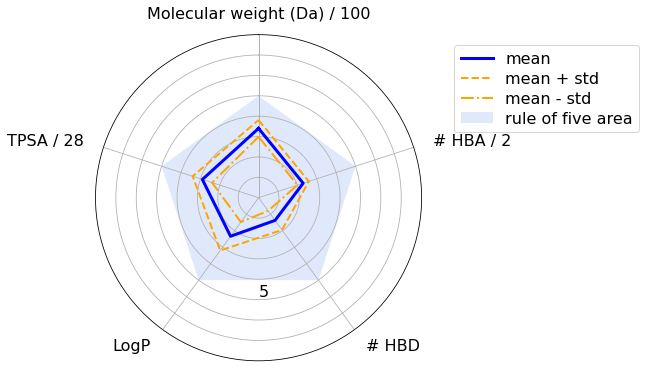

In [ ]:
plot_radar(
    MoleculeDatabase_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

The blue square shows the area where a molecule's physicochemical properties are compliant with the Ro5. The blue line highlights the mean values, while the orange dashed lines show the standard deviations. We can see that the mean values never violate any of Lipinski's rules. However, according to the standard deviation, some properties have larger values then the Ro5 thresholds. This is acceptable because, according to the Ro5, one of the four rules can be violated.

    We plot the radarplot for the dataset of compounds that violate the Ro5.



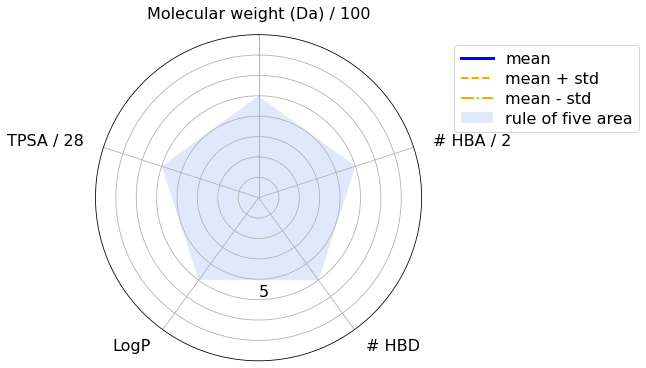

In [ ]:
plot_radar(
    MoleculeDatabase_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

We see that compounds mostly violate the Ro5 because of their logP values and their molecular weight.


Plotting histograms

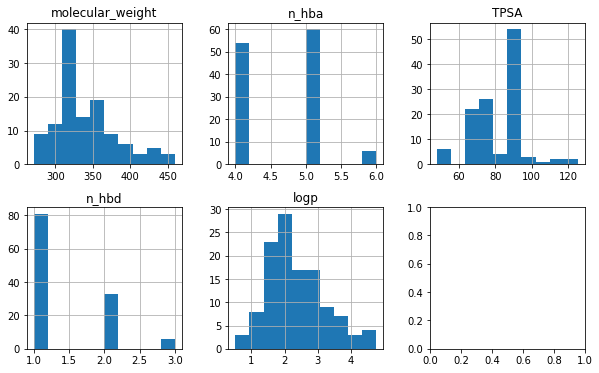

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=3)
MoleculeDatabase_ro5_fulfilled.hist(["molecular_weight"], ax=axes[0, 0])
MoleculeDatabase_ro5_fulfilled.hist(["n_hba"], ax=axes[0, 1])
MoleculeDatabase_ro5_fulfilled.hist(["n_hbd"], ax=axes[1, 0])
MoleculeDatabase_ro5_fulfilled.hist(["logp"], ax=axes[1, 1])
MoleculeDatabase_ro5_fulfilled.hist(["TPSA"], ax=axes[0, 2])
fig;

In [ ]:
# Save filtered data
MoleculeDatabase_ro5_fulfilled.to_csv("MoleculeDatabase_compounds_lipinski.csv")
MoleculeDatabase_ro5_fulfilled.head()

,rmsd,ID,smiles,molecular_weight,n_hba,n_hbd,logp,TPSA,ro5_fulfilled
0,0.422508746,CHEMBL3693604,N#CCC(=O)N1CC[C@@]12CCCCN(c1ncnc3[nH]ccc13)C2,324.169859,5,1,1.83298,88.91,True
1,0.451724887,CHEMBL3689521,C[C@H]1C[C@]2(CCCN(c3ncnc4[nH]ccc34)C2)N1C(=O)...,324.169859,5,1,1.83138,88.91,True
2,0.240224406,CHEMBL3689519,N#CCC(=O)N1CCC[C@@]12CCCN(c1ncnc3[nH]ccc13)C2,324.169859,5,1,1.83298,88.91,True
3,0.43335253,CHEMBL3689526,CC1(C)CN(C(=O)CC#N)[C@@]12CCCN(c1ncnc3[nH]ccc1...,338.185509,5,1,2.07898,88.91,True
4,0.461102277,CHEMBL3693601,C[C@H]1CCN(C(=O)CC#N)[C@]12CCN(c1ncnc3[nH]ccc1...,324.169859,5,1,1.68888,88.91,True
